<a href="https://colab.research.google.com/github/Jarin160/Malaria-Diagnosis/blob/main/malaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
!unzip Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/train/Uninfected/C56P17thinF_IMG_20150728_160256_cell_12.png  
  inflating: Dataset/train/Uninfected/C56P17thinF_IMG_20150728_160256_cell_21.png  
  inflating: Dataset/train/Uninfected/C56P17thinF_IMG_20150728_160256_cell_30.png  
  inflating: Dataset/train/Uninfected/C56P17thinF_IMG_20150728_160256_cell_57.png  
  inflating: Dataset/train/Uninfected/C56P17thinF_IMG_20150728_160256_cell_59.png  
  inflating: Dataset/train/Uninfected/C56P17thinF_IMG_20150728_160256_cell_65.png  
  inflating: Dataset/train/Uninfected/C56P17thinF_IMG_20150728_160256_cell_79.png  
  inflating: Dataset/train/Uninfected/C56P17thinF_IMG_20150728_160256_cell_81.png  
  inflating: Dataset/train/Uninfected/C56P17thinF_IMG_20150728_160256_cell_99.png  
  inflating: Dataset/train/Uninfected/C56P17thinF_IMG_20150728_160438_cell_115.png  
  inflating: Dataset/train/Uninfected/C56P17thinF_IMG_20150728_160438_cell_16.png  
  inflating: Dataset/tra

In [4]:
IMAGE_SIZE = (224, 224)
batch_size = 32

train_path = 'Dataset/train'
val_path = 'Dataset/test'
test_path = 'Dataset/test'

In [5]:
cls_names = os.listdir(train_path)
print(cls_names)

['Uninfected', 'Parasitized']


In [6]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   )
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
train_set = train_datagen.flow_from_directory( train_path,
                                               target_size = IMAGE_SIZE,
                                               batch_size = batch_size,
                                               class_mode = 'categorical',
                                               shuffle=True)
val_set = val_datagen.flow_from_directory( val_path,
                                            target_size = IMAGE_SIZE,
                                            batch_size = batch_size,
                                            class_mode = 'categorical',
                                            shuffle=True)
test_set = test_datagen.flow_from_directory( test_path,
                                            target_size = IMAGE_SIZE,
                                            batch_size = batch_size,
                                            class_mode = 'categorical',
                                            shuffle=True)

Found 19290 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


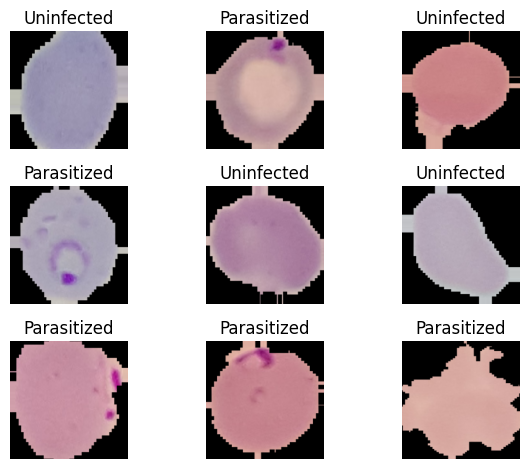

In [7]:
#Data visualization

for i in range(min(len(train_set[0][0]), 9)):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(train_set[0][0][i])

    class_names = list(train_set.class_indices.keys())
    plt.title(class_names[np.argmax(train_set[0][1][i])])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
vgg_model = VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)

for layer in vgg_model.layers:
    layer.trainable = False

folders = glob('Dataset/train/*')
num_classes = len(folders)

model1 = Sequential([
    vgg_model,
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model1.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,905,218 (125.52 MB)

 Trainable params: 12,879,682 (49.13 MB)

 Non-trainable params: 20,025,536 (76.39 MB)

In [9]:
earlystop = EarlyStopping(monitor = 'val_loss', patience=10, verbose= 1, restore_best_weights=True)

learning_rate = ReduceLROnPlateau(monitor= 'val_loss', patience=3, verbose= 1)

callbacks=[earlystop,learning_rate]

In [14]:
model1.compile(
  optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4),
  loss = tf.keras.losses.CategoricalCrossentropy(),
  metrics=['accuracy']
)
history = model1.fit(
  train_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(train_set),
  validation_steps=len(test_set),
  callbacks=callbacks,
)

Epoch 1/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 314s 512ms/step - accuracy: 0.9020 - loss: 0.2444 - val_accuracy: 0.9084 - val_loss: 0.2233 - learning_rate: 1.0000e-04
Epoch 2/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 300s 497ms/step - accuracy: 0.9106 - loss: 0.2340 - val_accuracy: 0.9262 - val_loss: 0.1895 - learning_rate: 1.0000e-04
Epoch 3/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 295s 488ms/step - accuracy: 0.9095 - loss: 0.2292 - val_accuracy: 0.9202 - val_loss: 0.2043 - learning_rate: 1.0000e-04
Epoch 4/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 297s 493ms/step - accuracy: 0.9122 - loss: 0.2242 - val_accuracy: 0.9200 - val_loss: 0.1999 - learning_rate: 1.0000e-04
Epoch 5/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.9149 - loss: 0.2217
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
603/603 ━━━━━━━━━━━━━━━━━━━━ 294s 487ms/step - accuracy: 0.9149 - loss: 0.2217 - val_accuracy: 0.9227 - val_loss: 0.2044 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epo

In [15]:
vgg_scores = model1.evaluate(test_set)
print(vgg_scores)

173/173 ━━━━━━━━━━━━━━━━━━━━ 36s 209ms/step - accuracy: 0.9299 - loss: 0.1806
[0.18954753875732422, 0.9261611104011536]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


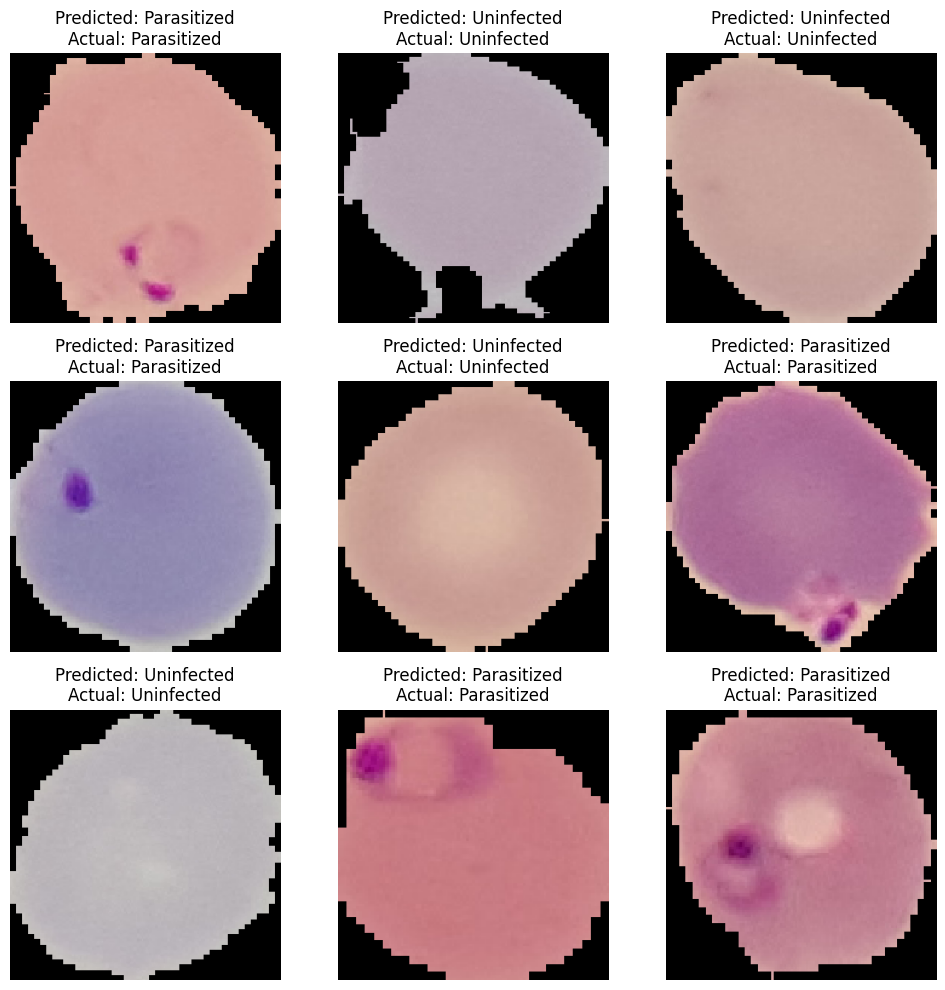

In [19]:
test_images, test_labels = next(test_set)

# Get predictions for the batch
predictions = model1.predict(test_images)

# Convert predictions from one-hot encoded to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Display some images with predictions and actual labels
num_images_to_show = 9  # You can change this number
plt.figure(figsize=(10, 10))

for i in range(min(num_images_to_show, len(test_images))):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i])
    class_names = list(test_set.class_indices.keys())
    predicted_label = class_names[predicted_classes[i]]
    true_label = class_names[true_classes[i]]
    plt.title(f"Predicted: {predicted_label}\nActual: {true_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()